In [ ]:
import cv2
import numpy as np
import glob
import open3d as o3d

In [ ]:
# Calibration pattern settings
chessboard_size = (8, 5)                # 8x5 inner corners on the chessboard
objp = np.zeros((np.prod(chessboard_size), 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp = objp * 3
# Note: objp will be like [[0,0,0], [1,0,0], ..., [8,5,0]] assuming square size = 1 unit.

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Load calibration images
calib_images = glob.glob('C:/Users/chauh/Desktop/Structure-From-Motion/Dataset/chessboard/*.JPG')
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    if ret:
        # Refine corner locations for more accuracy
        term_crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_sub = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), term_crit)
        objpoints.append(objp)
        imgpoints.append(corners_sub)
        # Optionally draw corners and display or save the image for verification
        cv2.drawChessboardCorners(img, chessboard_size, corners_sub, ret)
       
# Perform camera calibration to get intrinsic parameters
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None)

# Save the camera calibration results (intrinsic matrix and distortion coefficients)
print("Camera intrinsic matrix:\n", camera_matrix)
print("Distortion coefficients:\n", dist_coeffs.ravel())
print(ret)

Camera intrinsic matrix:
 [[3.07524255e+03 0.00000000e+00 1.54281151e+03]
 [0.00000000e+00 3.06749123e+03 2.05418720e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients:
 [ 0.47835841 -3.04454616  0.00869944  0.00755471  7.3949647 ]
3.484902300260686


In [ ]:
# Load images for SfM
image_paths = sorted(glob.glob('C:/Users/chauh/Desktop/Structure-From-Motion/Dataset/sippu/*.JPG'))

images = [cv2.imread(p) for p in image_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for all images
keypoints_list = []
descriptors_list = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = sift.detectAndCompute(gray, None)
    keypoints_list.append(kp)
    descriptors_list.append(desc)
    print(f"Detected {len(kp)} SIFT keypoints in image.")

# Feature matching between image 0 and image 1 as an example
idx1, idx2 = 0, 1
des1 = descriptors_list[idx1]
des2 = descriptors_list[idx2]
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)
print(f"Found {len(matches)} raw matches between image {idx1} and {idx2}.")

Detected 61432 SIFT keypoints in image.
Detected 59422 SIFT keypoints in image.
Detected 54880 SIFT keypoints in image.
Detected 55880 SIFT keypoints in image.
Detected 55450 SIFT keypoints in image.
Detected 53778 SIFT keypoints in image.
Detected 51324 SIFT keypoints in image.
Detected 51206 SIFT keypoints in image.
Detected 51249 SIFT keypoints in image.
Detected 50251 SIFT keypoints in image.
Detected 50271 SIFT keypoints in image.
Detected 48688 SIFT keypoints in image.
Detected 49856 SIFT keypoints in image.
Detected 44677 SIFT keypoints in image.
Detected 47923 SIFT keypoints in image.
Detected 38490 SIFT keypoints in image.
Detected 23733 SIFT keypoints in image.
Detected 32157 SIFT keypoints in image.
Detected 30501 SIFT keypoints in image.
Detected 27602 SIFT keypoints in image.
Detected 27990 SIFT keypoints in image.
Detected 27274 SIFT keypoints in image.
Detected 32035 SIFT keypoints in image.
Detected 32340 SIFT keypoints in image.
Detected 30239 SIFT keypoints in image.


In [ ]:
# Lowe's ratio test to filter good matches
good_matches = []
ratio_thresh = 0.75
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
print(f"{len(good_matches)} matches passed the ratio test.")

# Prepare points from the good matches
pts1 = np.float32([ keypoints_list[idx1][m.queryIdx].pt for m in good_matches ])
pts2 = np.float32([ keypoints_list[idx2][m.trainIdx].pt for m in good_matches ])

# Remove outliers using the fundamental matrix (RANSAC)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 3.0, 0.99)
mask = mask.ravel()
inliers_pts1 = pts1[mask==1]
inliers_pts2 = pts2[mask==1]
print(f"{len(inliers_pts1)} inlier matches after RANSAC outlier removal.")

22006 matches passed the ratio test.
21478 inlier matches after RANSAC outlier removal.


In [ ]:
# Assume camera_matrix from calibration is available as K
K = camera_matrix

# Use inlier correspondences from image 0 and 1 to compute Essential matrix
E, mask_E = cv2.findEssentialMat(inliers_pts1, inliers_pts2, K, method=cv2.RANSAC, 
                                 prob=0.999, threshold=1.0)
# Recover relative pose between image 0 (reference) and image 1
_, R_rel, t_rel, mask_pose = cv2.recoverPose(E, inliers_pts1, inliers_pts2, K)
# Set initial camera poses: camera 0 at origin, camera 1 with pose (R01, t01)
R0 = np.eye(3, dtype=np.float64)
t0 = np.zeros((3,1), dtype=np.float64)
R1 = R0 @ R_rel
t1 = R0 @ t_rel + t0
R_world = [R0, R1]
t_world = [t0, t1]

In [ ]:
# Triangulate points between camera 0 and 1
# Compute projection matrices for triangulation
P0 = K @ np.hstack((R_world[0], t_world[0]))   # = K[I|0]
P1 = K @ np.hstack((R_world[1], t_world[1]))   # = K[R01|t01]
# Triangulate inlier match points (need to reshape to 2xN for function)
pts1_hom = inliers_pts1.T  # shape (2, N)
pts2_hom = inliers_pts2.T  # shape (2, N)
points4D = cv2.triangulatePoints(P0, P1, pts1_hom, pts2_hom)
points4D /= points4D[3]  # convert homogeneous coords to 1 (divide by fourth row)
point_cloud = points4D[:3].T  # Nx3 array of 3D points in world coordinate
print(f"Triangulated {point_cloud.shape[0]} points from initial pair.")

Triangulated 21478 points from initial pair.


In [ ]:
# Continue incremental SfM for subsequent images
for i in range(2, len(images)):
    # a) Match features between image (i-1) and image i
    des_prev = descriptors_list[i-1]
    des_curr = descriptors_list[i]
    matches_i = bf.knnMatch(des_prev, des_curr, k=2)
    
    good_i = []
    for m, n in matches_i:
        if m.distance < ratio_thresh * n.distance:
            good_i.append(m)
    
    pts_prev = np.float32([keypoints_list[i-1][m.queryIdx].pt for m in good_i])
    pts_curr = np.float32([keypoints_list[i][m.trainIdx].pt for m in good_i])

    # (Optional but recommended) outlier removal again:
    #   either via fundamental or essential matrix:
    F_i, mask_Fi = cv2.findFundamentalMat(pts_prev, pts_curr, cv2.FM_RANSAC, 3.0, 0.99)
    mask_Fi = mask_Fi.ravel().astype(bool)
    pts_prev_in = pts_prev[mask_Fi]
    pts_curr_in = pts_curr[mask_Fi]

    # b) Compute E and recover relative pose
    E_i, _ = cv2.findEssentialMat(pts_prev_in, pts_curr_in, K, cv2.RANSAC, 0.999, 1.0)
    _, R_rel_i, t_rel_i, _ = cv2.recoverPose(E_i, pts_prev_in, pts_curr_in, K)

    # c) Compose with pose of camera (i-1)
    R_prev = R_world[i-1]
    t_prev = t_world[i-1]
    
    # Correct ordering for composition:
    R_i = R_prev @ R_rel_i
    t_i = R_prev @ t_rel_i + t_prev

    R_world.append(R_i)
    t_world.append(t_i)

    # d) Triangulate new 3D points from (i-1) and i
    P_prev = K @ np.hstack((R_prev, t_prev))
    P_i    = K @ np.hstack((R_i, t_i))
    pts_prev_hom = pts_prev_in.T
    pts_curr_hom = pts_curr_in.T
    new_4D = cv2.triangulatePoints(P_prev, P_i, pts_prev_hom, pts_curr_hom)
    new_4D /= new_4D[3]
    new_points = new_4D[:3].T  # Nx3

    # e) Merge into global point cloud
    point_cloud = np.vstack((point_cloud, new_points))
    print(f"[View {i}] -> Pose recovered, triangulated {new_points.shape[0]} new points. Total = {point_cloud.shape[0]}.")

    # Merge new_points into the global point cloud (simple concatenation here)
    point_cloud = np.vstack((point_cloud, new_points))
    print(f"Image {i}: pose estimated, triangulated {new_points.shape[0]} new points (total points = {point_cloud.shape[0]})")

[View 2] -> Pose recovered, triangulated 17414 new points. Total = 38892.
Image 2: pose estimated, triangulated 17414 new points (total points = 56306)
[View 3] -> Pose recovered, triangulated 18728 new points. Total = 75034.
Image 3: pose estimated, triangulated 18728 new points (total points = 93762)
[View 4] -> Pose recovered, triangulated 18925 new points. Total = 112687.
Image 4: pose estimated, triangulated 18925 new points (total points = 131612)
[View 5] -> Pose recovered, triangulated 12986 new points. Total = 144598.
Image 5: pose estimated, triangulated 12986 new points (total points = 157584)
[View 6] -> Pose recovered, triangulated 16839 new points. Total = 174423.
Image 6: pose estimated, triangulated 16839 new points (total points = 191262)
[View 7] -> Pose recovered, triangulated 17557 new points. Total = 208819.
Image 7: pose estimated, triangulated 17557 new points (total points = 226376)
[View 8] -> Pose recovered, triangulated 14993 new points. Total = 241369.
Image

Camera centers (trajectory points):
 [[ 0.          0.          0.        ]
 [-0.70153395 -0.65570698  0.27910297]
 [-0.4994885  -0.57199575 -0.65928495]
 [-1.25858849  0.28151069 -0.72377509]
 [-2.25302964 -0.03131734 -0.85555757]
 [-1.44292053 -0.13951597 -0.92244314]
 [-0.40564141 -0.11323846 -1.43211222]
 [-0.38786836 -0.33692765 -2.40530685]
 [-0.85267514 -1.35530065 -2.47915585]
 [-0.38303114  0.03601108 -2.70218508]
 [-1.50281751 -0.16287334 -2.6489756 ]
 [-3.04516804  0.36728059 -1.71768028]
 [-0.98433389 -0.54209429 -2.63177894]
 [-3.18147439 -0.55386841 -1.60288988]
 [-1.2960842  -0.10976224 -2.39951223]
 [-1.45942979 -1.60444368 -2.63530037]
 [-1.51388946 -1.72069104 -1.60213198]
 [-0.40731913 -1.46993599 -1.67545862]
 [-0.98135934 -2.81166373 -1.18924415]
 [-2.05137788 -2.91720937 -0.94714413]
 [-2.37728254  1.11402696 -1.49685219]
 [ 0.77020799  3.23141965  0.9300353 ]
 [ 1.30614719  3.60156253  1.354694  ]
 [ 1.45543069  2.82186768  0.48162634]
 [-0.4994885  -0.57199575 -

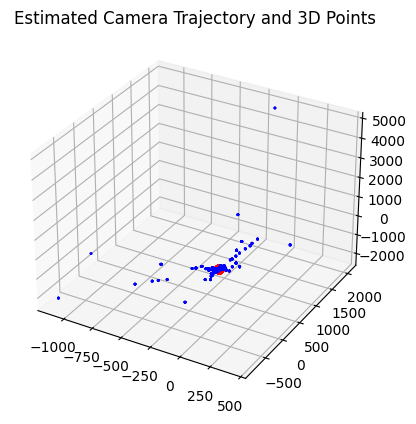

In [ ]:
# Compute camera centers in world frame for visualization
camera_centers = []
for R, t in zip(R_world, t_world):
    C = -R.T @ t  # camera center in world coordinates
    camera_centers.append(C.flatten())
camera_centers = np.array(camera_centers)  # shape (num_images, 3)
print("Camera centers (trajectory points):\n", camera_centers)

# (Optional) Visualize camera trajectory and point cloud using matplotlib (not executed here)
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=1, c='blue', label='Points')
ax.plot(camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], c='red', marker='o', label='Camera trajectory')
ax.set_title('Estimated Camera Trajectory and 3D Points')
plt.show()

In [ ]:
# Save the 3D point cloud to a PLY file
output_ply = 'reconstruction.ply'
points = point_cloud  # assuming point_cloud is an (N,3) array of XYZ points
with open(output_ply, 'w') as f:
    # Write PLY header
    f.write("ply\nformat ascii 1.0\n")
    f.write(f"element vertex {points.shape[0]}\n")
    f.write("property float x\nproperty float y\nproperty float z\n")
    f.write("end_header\n")
    # Write vertex data
    for p in points:
        f.write(f"{p[0]} {p[1]} {p[2]}\n")
print(f"3D point cloud saved to {output_ply}")

3D point cloud saved to reconstruction.ply


In [ ]:
def extract_colors(image, points_2d):
    """
    Extracts RGB colors for the given 2D feature points from an image.
    
    :param image: The original color image (BGR format from OpenCV)
    :param points_2d: Nx2 array of pixel coordinates
    :return: Nx3 array of RGB colors
    """
    colors = []
    for pt in points_2d:
        x, y = int(pt[0]), int(pt[1])  # Convert to integer pixel coordinates
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:  # Ensure within bounds
            b, g, r = image[y, x]  # OpenCV stores as BGR
            colors.append((r, g, b))  # Convert to RGB format
        else:
            colors.append((255, 255, 255))  # Default white if out of bounds
    return np.array(colors, dtype=np.uint8)

# Assume image_1 is the reference image
image_1 = images[1]

# Extract colors for each point using first image
colors = extract_colors(image_1, pts1)

def save_colored_point_cloud_ply(filename, points, colors):
    """
    Saves a 3D point cloud with colors in PLY format.

    :param filename: Output PLY file path
    :param points: Nx3 NumPy array of XYZ points
    :param colors: Nx3 NumPy array of RGB colors
    """
    with open(filename, 'w') as f:
        # Write PLY header
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {points.shape[0]}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")

        # Write point data (XYZ + RGB)
        for p, c in zip(points, colors):
            f.write(f"{p[0]} {p[1]} {p[2]} {c[0]} {c[1]} {c[2]}\n")

output_ply = "reconstruction_colored.ply"
save_colored_point_cloud_ply(output_ply, point_cloud, colors)

print(f"[Info] Saved colored point cloud with {point_cloud.shape[0]} points to {output_ply}")

[Info] Saved colored point cloud with 1357554 points to reconstruction_colored.ply


In [ ]:
# Load the point cloud
pcd = o3d.io.read_point_cloud("reconstruction_colored.ply")

# Estimate normals
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=50))
pcd.orient_normals_consistent_tangent_plane(k=100)  # Ensure outward normals

# Poisson Surface Reconstruction (increase depth)
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=12)

# Compute density threshold
densities = np.asarray(densities)
density_threshold = np.percentile(densities, 10)  # Adjust (10-20%) to remove weak areas

# Remove low-density regions (outer unwanted wrap)
vertices = np.asarray(mesh.vertices)
mesh_filtered = mesh.select_by_index(np.where(densities > density_threshold)[0])

# Save and visualize the cleaned mesh
o3d.io.write_triangle_mesh("mesh_poisson_trimmed.ply", mesh_filtered)
o3d.visualization.draw_geometries([mesh_filtered])